In [1]:
import csv
import pandas as pd
import numpy as np
import json
import jsonlines
import re
csv.field_size_limit(100000000)
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, classification_report, log_loss
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse
%matplotlib inline 

import matplotlib.dates as mdates
import matplotlib.ticker as tick

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.4f}'.format

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# **Logostic Regression** 
## *(1) TweetsCov19*
#### (Content + User Features)

In [2]:
#pfad_tsv = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/TweetsFormodel/tweetsCov19_sample_with_users_1_48.tsv'
pfad_tsv = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/TweetsCov19_sample/TweetsCov19_alle_geloeschten/TweetsCov19_all_del_posted.tsv'

df_tweetscov19_user = pd.read_csv(pfad_tsv, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Is_deleted', 'Retweets', 'Likes', 'Sentiment', 'Hashtags n.', 'Mentions n.', 'Text l.', 'URLs n.', 'Readability', 'Emoji n.', 'Emoji sentiment', 'Political p.T.', 'Science p.T.', 'Moderacy p.T.', 'Porn(Shalla)', 'News(Shalla)', 'Socialnet(Shalla)', 'Social', 'Family', 'Friend', 'Female', 'Male' , 'Work', 'Leisure', 'Home', 'Money', 'Relegion', 'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonfluence', 'Filler', 'Body', 'Health', 'Sexual', 'Ingest', 'Pos. emo.', 'Neg. emo.', 'Anxiety', 'Anger', 'Sadness', 'Insight', 'Cause', 'Discrep', 'Tentativness', 'Certainty', 'Differentiation', 'Affiliation', 'Achieve', 'Power', 'Reward', 'Risk', 'Focus past', 'Focus present', 'Focus future', 'I', 'We', 'You', 'SheHe', 'They', 'Ipron', 'Article', 'Preposition', 'Auxverb', 'Adverb', 'Conjunctive', 'Negate', 'Verb', 'Adjective', 'Compare', 'Interrogative', 'Number', 'Quantitative', 'See', 'Hear', 'Feel', 'Motion', 'Space', 'Time', 'Political p.u.', 'Science p.u.', 'Moderacy p.u.', 'Posted n.', 'Deleted n.', 'Deletion ratio', 'Reputation' ])

print('Shape :', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape : (4275002, 90)


,Tweet_Id,Username,Is_deleted,Retweets,Likes,Sentiment,Hashtags n.,Mentions n.,Text l.,URLs n.,Readability,Emoji n.,Emoji sentiment,Political p.T.,Science p.T.,Moderacy p.T.,Porn(Shalla),News(Shalla),Socialnet(Shalla),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonfluence,Filler,Body,Health,Sexual,Ingest,Pos. emo.,Neg. emo.,Anxiety,Anger,Sadness,Insight,Cause,Discrep,Tentativness,Certainty,Differentiation,Affiliation,Achieve,Power,Reward,Risk,Focus past,Focus present,Focus future,I,We,You,SheHe,They,Ipron,Article,Preposition,Auxverb,Adverb,Conjunctive,Negate,Verb,Adjective,Compare,Interrogative,Number,Quantitative,See,Hear,Feel,Motion,Space,Time,Political p.u.,Science p.u.,Moderacy p.u.,Posted n.,Deleted n.,Deletion ratio,Reputation
0,1208681135871418368,24862c132c99e3fd8dd438dede442aff,False,0,0,-0.3724,0,0,89,0,100.0040,0,0.0000,0,0,0,0.0000,0.0000,0.0000,10.0000,0.0000,5.0000,0.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,5.0000,5.0000,10.0000,5.0000,5.0000,15.0000,0.0000,15.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,10.0000,5.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.9986
1,1185315121620488195,97a449b4b6d5c6d5250f83ce128f5007,False,3978,11388,-0.4585,0,0,71,0,87.9450,0,0.0000,0,0,0,0.0000,0.0000,0.0000,14.2900,7.1400,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,14.2900,7.1400,0.0000,0.0000,7.1400,7.1400,7.1400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,71,5,0.0704,1.0000
2,1240303004147945475,363cdbdd7e38b1391f5029d6fa57512d,False,46,97,0.0516,0,0,165,0,72.6050,0,0.0000,0,0,0,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,3.4500,0.0000,3.4500,0.0000,6.9000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.9000,6.9000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,10.3400,3.4500,3.4500,10.3400,3.4500,0.0000,13.7900,6.9000,3.4500,3.4500,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,2,0,0.0000,0.5398
3,1243334773323575297,9b12d5802c13f5aa06f682d58063ec8e,False,0,0,0.0000,0,1,13,0,77.9050,0,0.0000,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.4293
4,1239476655854432257,57923a593be30eb12ee697d352c83598,False,25,36,0.5574,0,1,137,1,35.6620,0,0.0000,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.5300,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,1231,19,0.0154,0.9990


In [3]:
df_tweetscov19_user.head()

,Tweet_Id,Username,Is_deleted,Retweets,Likes,Sentiment,Hashtags n.,Mentions n.,Text l.,URLs n.,Readability,Emoji n.,Emoji sentiment,Political p.T.,Science p.T.,Moderacy p.T.,Porn(Shalla),News(Shalla),Socialnet(Shalla),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonfluence,Filler,Body,Health,Sexual,Ingest,Pos. emo.,Neg. emo.,Anxiety,Anger,Sadness,Insight,Cause,Discrep,Tentativness,Certainty,Differentiation,Affiliation,Achieve,Power,Reward,Risk,Focus past,Focus present,Focus future,I,We,You,SheHe,They,Ipron,Article,Preposition,Auxverb,Adverb,Conjunctive,Negate,Verb,Adjective,Compare,Interrogative,Number,Quantitative,See,Hear,Feel,Motion,Space,Time,Political p.u.,Science p.u.,Moderacy p.u.,Posted n.,Deleted n.,Deletion ratio,Reputation
0,1208681135871418368,24862c132c99e3fd8dd438dede442aff,False,0,0,-0.3724,0,0,89,0,100.0040,0,0.0000,0,0,0,0.0000,0.0000,0.0000,10.0000,0.0000,5.0000,0.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,5.0000,5.0000,10.0000,5.0000,5.0000,15.0000,0.0000,15.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,10.0000,5.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.9986
1,1185315121620488195,97a449b4b6d5c6d5250f83ce128f5007,False,3978,11388,-0.4585,0,0,71,0,87.9450,0,0.0000,0,0,0,0.0000,0.0000,0.0000,14.2900,7.1400,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,14.2900,7.1400,0.0000,0.0000,7.1400,7.1400,7.1400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,71,5,0.0704,1.0000
2,1240303004147945475,363cdbdd7e38b1391f5029d6fa57512d,False,46,97,0.0516,0,0,165,0,72.6050,0,0.0000,0,0,0,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,3.4500,0.0000,3.4500,0.0000,6.9000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.9000,6.9000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,10.3400,3.4500,3.4500,10.3400,3.4500,0.0000,13.7900,6.9000,3.4500,3.4500,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,2,0,0.0000,0.5398
3,1243334773323575297,9b12d5802c13f5aa06f682d58063ec8e,False,0,0,0.0000,0,1,13,0,77.9050,0,0.0000,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.4293
4,1239476655854432257,57923a593be30eb12ee697d352c83598,False,25,36,0.5574,0,1,137,1,35.6620,0,0.0000,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.5300,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,1231,19,0.0154,0.9990


In [4]:
df_tweetscov19_user.Username.unique().size

2249636

In [5]:
df_tweetscov19_user.Username.unique().size

2249636

In [6]:
df_tweetscov19_del = df_tweetscov19_user[df_tweetscov19_user['Is_deleted']==True]
df_tweetscov19_undel = df_tweetscov19_user[df_tweetscov19_user['Is_deleted']==False]

In [29]:
def plot_paiplot(df, hue, titel): 
   
    #plt.rcParams["figure.figsize"] = [6,4]
    #fig, ax = plt.subplots()
    sns.pairplot(df, hue = hue)

    #ax.set_ylabel('Dataframe')

    #ax.set_xlabel('Deletion ratio', fontsize=12)
    #plt.margins(0.02)
    #fig.tight_layout()
    #plt.show()

    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/log_reg/'+titel+'.jpg')

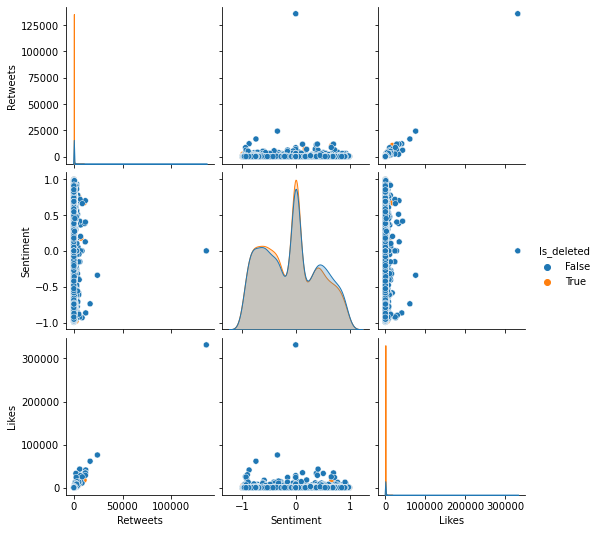

In [30]:
df = df_tweetscov19_user[['Is_deleted', 'Retweets', 'Sentiment', 'Likes']]
plot_paiplot(df, 'Is_deleted', 'pairplot_tweetsocv19_Retweet_favoriet_sentiment')

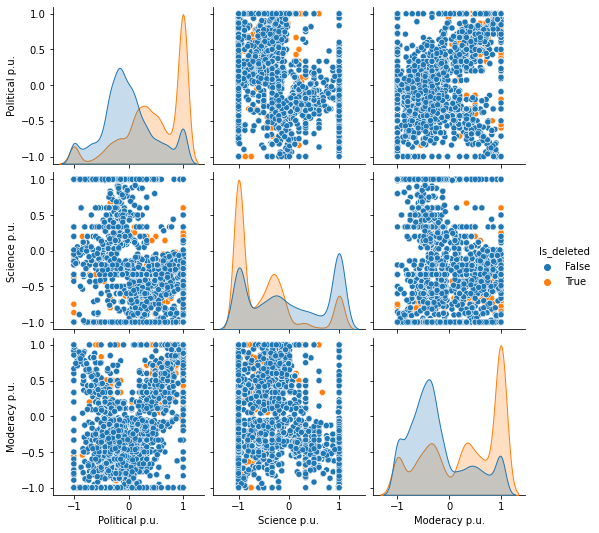

In [31]:
df = df_tweetscov19_user[['Is_deleted', 'Political p.u.', 'Science p.u.', 'Moderacy p.u.']]
plot_paiplot(df, 'Is_deleted', 'pairplot_tweetsocv19_politic_science_moderacy')

In [2]:
def plot_kdeplot(df, hue, x, x_label, titel, name): 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    g = sns.kdeplot(data=df, x=x, hue=hue, fill=True, legend= False)
    #plt.rcParams["figure.figsize"] = [7,5]

    #ax.set_ylabel('Dataframe')

    g.set_xlabel(x_label, fontsize=14)
    #plt.margins(0.02)
    #fig.tight_layout()
    #plt.show()
    plt.legend(labels = ['Deleted','Non-deleted'], bbox_to_anchor=(0.3, 1.1), ncol=2, loc=2, borderaxespad=0)
    #g.set_title(titel, fontweight="bold")
    #plt.legend(labels = ['Deleted','Non-deleted'], bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0)
    plt.tight_layout()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/log_reg/'+name+'.jpg')


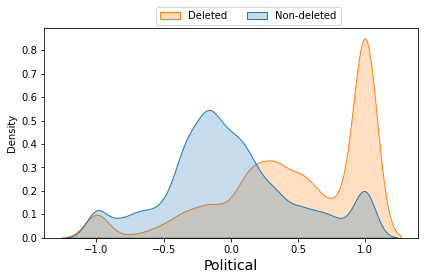

In [96]:
df = df_tweetscov19_user[['Is_deleted', 'Political p.u.']]
plot_kdeplot(df, 'Is_deleted','Political p.u.' ,'Political' ,'TweetsCov19', 'kdeplot_tweetsocv19_politic')

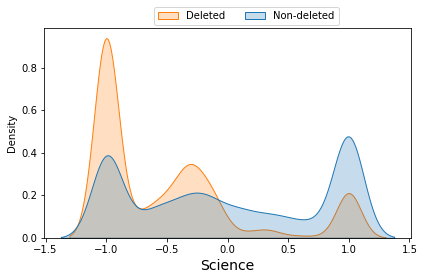

In [97]:
df = df_tweetscov19_user[['Is_deleted', 'Science p.u.']]
plot_kdeplot(df, 'Is_deleted', 'Science p.u.', 'Science', 'TweetsCov19', 'kdeplot_tweetsocv19_science')

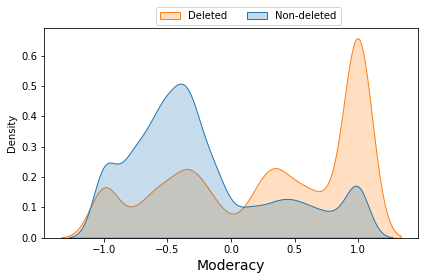

In [98]:
df = df_tweetscov19_user[['Is_deleted', 'Moderacy p.u.']]
plot_kdeplot(df, 'Is_deleted', 'Moderacy p.u.','Moderacy' ,'TweetsCov19', 'kdeplot_tweetsocv19_moderacy')

<AxesSubplot:xlabel='Is_deleted', ylabel='count'>

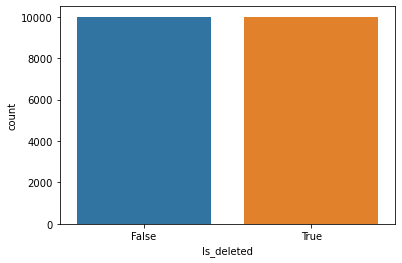

In [12]:
sns.countplot(x = 'Is_deleted', data = df)

In [7]:
features = df_tweetscov19_user.columns
features

Index(['Tweet_Id', 'Username', 'Is_deleted', 'Retweets', 'Likes', 'Sentiment',
       'Hashtags n.', 'Mentions n.', 'Text l.', 'URLs n.', 'Readability',
       'Emoji n.', 'Emoji sentiment', 'Political p.T.', 'Science p.T.',
       'Moderacy p.T.', 'Porn(Shalla)', 'News(Shalla)', 'Socialnet(Shalla)',
       'Social', 'Family', 'Friend', 'Female', 'Male', 'Work', 'Leisure',
       'Home', 'Money', 'Relegion', 'Death', 'Informal', 'Swear', 'Netspeak',
       'Assent', 'Nonfluence', 'Filler', 'Body', 'Health', 'Sexual', 'Ingest',
       'Pos. emo.', 'Neg. emo.', 'Anxiety', 'Anger', 'Sadness', 'Insight',
       'Cause', 'Discrep', 'Tentativness', 'Certainty', 'Differentiation',
       'Affiliation', 'Achieve', 'Power', 'Reward', 'Risk', 'Focus past',
       'Focus present', 'Focus future', 'I', 'We', 'You', 'SheHe', 'They',
       'Ipron', 'Article', 'Preposition', 'Auxverb', 'Adverb', 'Conjunctive',
       'Negate', 'Verb', 'Adjective', 'Compare', 'Interrogative', 'Number',
       'Quanti

In [8]:
df_tweetscov19_user['Is_deleted'] = np.where(df_tweetscov19_user['Is_deleted'] == True, 0, 1)

In [9]:
df_tweetscov19_user.tail()

,Tweet_Id,Username,Is_deleted,Retweets,Likes,Sentiment,Hashtags n.,Mentions n.,Text l.,URLs n.,Readability,Emoji n.,Emoji sentiment,Political p.T.,Science p.T.,Moderacy p.T.,Porn(Shalla),News(Shalla),Socialnet(Shalla),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonfluence,Filler,Body,Health,Sexual,Ingest,Pos. emo.,Neg. emo.,Anxiety,Anger,Sadness,Insight,Cause,Discrep,Tentativness,Certainty,Differentiation,Affiliation,Achieve,Power,Reward,Risk,Focus past,Focus present,Focus future,I,We,You,SheHe,They,Ipron,Article,Preposition,Auxverb,Adverb,Conjunctive,Negate,Verb,Adjective,Compare,Interrogative,Number,Quantitative,See,Hear,Feel,Motion,Space,Time,Political p.u.,Science p.u.,Moderacy p.u.,Posted n.,Deleted n.,Deletion ratio,Reputation
4274997,1267229106665594880,c0ebfec452331b0321736721a4c7c397,0,0,0,0.1680,0,0,38,0,117.6680,0,0.0000,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.1100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,22.2200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.1100,0.0000,0.0000,11.1100,0.0000,0.0000,0.0000,22.2200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.4580
4274998,1267229127641370624,0e855270aad244da5e92254d521eb148,0,0,0,-0.8074,0,0,126,0,59.2060,1,-0.1220,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.5200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.5200,4.7600,9.5200,4.7600,19.0500,0.0000,0.0000,9.5200,9.5200,0.0000,4.7600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.5200,14.2900,0.0000,0.0000,0.0000,1,1,1.0000,0.2161
4274999,1267229133974585344,d8c8fc2fd207b51ff22c35f2d671fb5b,0,16,82,0.0000,0,0,86,0,46.6050,0,0.0000,0,0,0,0.0000,0.0000,0.0000,6.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.2500,0.0000,6.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.2500,0.0000,6.2500,0.0000,0.0000,0.0000,12.5000,6.2500,0.0000,6.2500,0.0000,0.0000,0.0000,6.2500,0.0000,0.0000,6.2500,0.0000,0.0000,0.0000,18.7500,6.2500,0.0000,0.0000,6.2500,0.0000,6.2500,0.0000,0.0000,6.2500,6.2500,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.4271
4275000,1267229232503144448,83dc79690a7bbd520c847e072a042342,0,0,0,-0.7430,2,0,117,1,66.7190,0,0.0000,0,0,0,0.0000,0.0000,0.0000,15.7900,5.2600,5.2600,10.5300,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,5.2600,5.2600,0.0000,0.0000,0.0000,0.0000,10.5300,0.0000,10.5300,0.0000,0.0000,5.2600,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.5300,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,5.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.5300,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.0000
4275001,1267229337348014080,8f7917a02817a7741b871cf4f49e0337,0,0,0,-0.4588,0,0,198,0,30.4960,0,0.0000,0,0,0,0.0000,0.0000,0.0000,11.4300,2.8600,0.0000,0.0000,0.0000,0.0000,2.8600,2.8600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.8600,5.7100,0.0000,0.0000,0.0000,0.0000,5.7100,0.0000,2.8600,0.0000,0.0000,2.8600,5.7100,0.0000,2.8600,0.0000,0.0000,0.0000,5.7100,2.8600,5.7100,17.1400,5.7100,8.5700,11.4300,0.0000,8.5700,2.8600,0.0000,8.5700,0.0000,2.8600,2.8600,0.0000,0.0000,0.0000,8.5700,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.5566


In [10]:
features = features[2:90]
print(len(features))
features

88


Index(['Is_deleted', 'Retweets', 'Likes', 'Sentiment', 'Hashtags n.',
       'Mentions n.', 'Text l.', 'URLs n.', 'Readability', 'Emoji n.',
       'Emoji sentiment', 'Political p.T.', 'Science p.T.', 'Moderacy p.T.',
       'Porn(Shalla)', 'News(Shalla)', 'Socialnet(Shalla)', 'Social', 'Family',
       'Friend', 'Female', 'Male', 'Work', 'Leisure', 'Home', 'Money',
       'Relegion', 'Death', 'Informal', 'Swear', 'Netspeak', 'Assent',
       'Nonfluence', 'Filler', 'Body', 'Health', 'Sexual', 'Ingest',
       'Pos. emo.', 'Neg. emo.', 'Anxiety', 'Anger', 'Sadness', 'Insight',
       'Cause', 'Discrep', 'Tentativness', 'Certainty', 'Differentiation',
       'Affiliation', 'Achieve', 'Power', 'Reward', 'Risk', 'Focus past',
       'Focus present', 'Focus future', 'I', 'We', 'You', 'SheHe', 'They',
       'Ipron', 'Article', 'Preposition', 'Auxverb', 'Adverb', 'Conjunctive',
       'Negate', 'Verb', 'Adjective', 'Compare', 'Interrogative', 'Number',
       'Quantitative', 'See', 'Hear', 

In [11]:
df_tweetscov19_user_2 = df_tweetscov19_user[features.tolist()]
df_tweetscov19_user_2 = df_tweetscov19_user_2.drop(columns=[ 'Moderacy p.T.','Moderacy p.u.', 'Posted n.', 'Deleted n.','Deletion ratio'])
df = df_tweetscov19_user_2.drop('Is_deleted', axis=1)
X = df_tweetscov19_user_2.drop('Is_deleted', axis=1).values
y = df_tweetscov19_user_2['Is_deleted']

y = y.astype(int)
print(X.shape)
print(y.shape)

(4275002, 82)
(4275002,)


In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

def features_classifier(df, X, y):

    decisionTC = DecisionTreeClassifier(random_state=15, criterion= 'entropy', max_depth = 10)
    decisionTC.fit(X,y)
    
    column_feature = {}

    for i, c in enumerate(df):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = decisionTC.feature_importances_[i]
        
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)
    
    return df_column_feature.reset_index()

In [13]:

df_dt_clf = features_classifier(df, X, y)
df_dt_clf

,index,Feature,importance
0,81,Reputation,0.3972
1,79,Political p.u.,0.1496
2,6,URLs n.,0.1192
3,80,Science p.u.,0.0813
4,3,Hashtags n.,0.0469
5,5,Text l.,0.0404
6,13,News(Shalla),0.0273
7,0,Retweets,0.0197
8,12,Porn(Shalla),0.0163
9,55,I,0.0136


In [14]:
df_dt_clf = df_dt_clf[df_dt_clf['importance']>0]
df_dt_clf = df_dt_clf.Feature.values
print(df_dt_clf)


['Reputation' 'Political p.u.' 'URLs n.' 'Science p.u.' 'Hashtags n.'
 'Text l.' 'News(Shalla)' 'Retweets' 'Porn(Shalla)' 'I' 'Informal'
 'Socialnet(Shalla)' 'Preposition' 'Mentions n.' 'Work' 'Readability'
 'Emoji n.' 'Swear' 'Likes' 'Sentiment' 'Sexual' 'Political p.T.' 'Verb'
 'Ipron' 'You' 'Emoji sentiment' 'Money' 'Social' 'Discrep'
 'Interrogative' 'Conjunctive' 'Number' 'Health' 'Certainty' 'We'
 'Neg. emo.' 'Affiliation' 'Netspeak' 'Differentiation' 'Death' 'Male'
 'Negate' 'Adverb' 'Insight' 'Body' 'Article' 'Time' 'Space' 'Female'
 'Achieve' 'Focus present' 'Focus past' 'Compare' 'Relegion' 'Pos. emo.'
 'SheHe' 'Risk' 'Adjective' 'Sadness' 'Motion' 'Power' 'Feel'
 'Tentativness' 'Home' 'Auxverb' 'Focus future' 'Leisure' 'They' 'Cause']


In [15]:
#X = df_tweetscov19_user_2[df_dt_clf.tolist()].values
X.shape

(4275002, 82)

In [4]:
def split_train_test_valid(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=15)
    #X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=15)
    print(X_train.shape)
    print(X_test.shape)
    #print(X_valid.shape)

    print(y_train.shape)
    print(y_test.shape)
    #print(y_valid.shape)
    return  X_train, X_test, y_train, y_test 

In [17]:
 X_train, X_test, y_train, y_test  = split_train_test_valid(X,y)

(3420001, 82)
(855001, 82)
(3420001,)
(855001,)


<AxesSubplot:xlabel='Is_deleted', ylabel='count'>

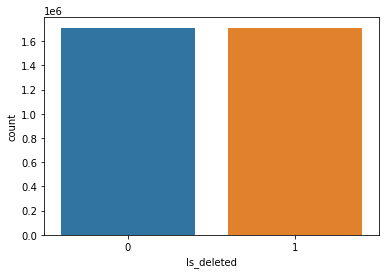

In [18]:
sns.countplot(x = y_train)

<AxesSubplot:xlabel='Is_deleted', ylabel='count'>

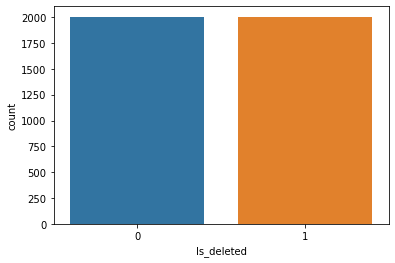

In [45]:
sns.countplot(x = y_test)

In [5]:
def fit_log_reg(X,y):
    l_regression = LogisticRegression(random_state=20, solver = 'lbfgs')
    l_regression.fit(X,y)
    return l_regression

In [20]:
l_regression = fit_log_reg(X_train, y_train)

In [21]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/LR_Benutzer_Inhalt_alle_ohne_moderacy.sav'
pickle.dump(l_regression, open(pfad_modell, 'wb'))

In [22]:
y_pred = l_regression.predict(X_train)

In [23]:
y_pred.shape

(3420001,)

In [24]:
y_prob = l_regression.predict_proba(X_train)
y_prob_test = l_regression.predict_proba(X_test)


In [25]:
print('Accuracy with useres featuresis : ',l_regression.score(X_train, y_train))

Accuracy with useres featuresis :  0.5674425241396128


In [26]:
print('Accuracy with useres featuresis : ',l_regression.score(X_test, y_test))

Accuracy with useres featuresis :  0.568039101708653


In [27]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.48      0.53   1709564
           1       0.56      0.65      0.60   1710437

    accuracy                           0.57   3420001
   macro avg       0.57      0.57      0.56   3420001
weighted avg       0.57      0.57      0.56   3420001



In [6]:
def plot_confusion_matrix(confu_matrix, classes, titel):
    sns.heatmap(confu_matrix, xticklabels = classes, yticklabels = classes, annot=True)
    plt.title(titel)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[0.48279327 0.51720673]
 [0.34795143 0.65204857]]


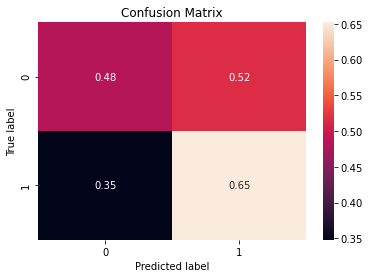

In [29]:
confusion_mx = confusion_matrix(y_train, y_pred)
confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(confusion_mx, l_regression.classes_, 'Confusion Matrix')
print(confusion_mx)

In [30]:
print('Logarithmic loss für Training data', log_loss(y_train, y_prob))
print('Logarithmic loss für Test data', log_loss(y_test, y_prob_test))

Logarithmic loss für Training data 0.6797940603554428
Logarithmic loss für Test data 0.6796975516863862


In [31]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/LR_Benutzer_Inhalt_alle_ohne_moderacy.sav'
#l_regression = pickle.load(open(pfad_modell, 'rb'))

In [32]:
scores = cross_val_score(l_regression, X_test, y_test, cv=10, scoring='precision')
print(" percision %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(l_regression, X_test, y_test, cv=10, scoring='f1')
print(" f1        %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(l_regression, X_test, y_test, cv=10, scoring='recall')
print(" recall    %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

 percision 0.56 +/- 0.002
 f1        0.60 +/- 0.002
 recall    0.64 +/- 0.006


****************************************************************************
****************************************************************************

### Tweetscov19
#### (Conten only)

In [34]:
features = df_tweetscov19_user.columns
features

features = features[2:83]
df_tweetscov19_user_2 = df_tweetscov19_user[features.tolist()]
df_tweetscov19_user_2 = df_tweetscov19_user_2.drop(columns=[ 'Moderacy p.T.'])

df = df_tweetscov19_user_2.drop('Is_deleted', axis=1)
X = df_tweetscov19_user_2.drop('Is_deleted', axis=1).values
y = df_tweetscov19_user_2['Is_deleted']

y = y.astype(int)
print(X.shape)
print(y.shape)

(4275002, 79)
(4275002,)


In [35]:
features_cl = features_classifier(df , X, y)
features_cl

,index,Feature,importance
0,6,URLs n.,0.2129
1,0,Retweets,0.1409
2,5,Text l.,0.0756
3,20,Work,0.0623
4,3,Hashtags n.,0.0585
5,13,News(Shalla),0.0566
6,11,Science p.T.,0.0506
7,10,Political p.T.,0.0473
8,7,Readability,0.0363
9,62,Preposition,0.0283


In [36]:
features_cl = features_cl[features_cl['importance']>0]
features_cl = features_cl.Feature.values
print('Number of selected features: ', len(features_cl))
print()
print(features_cl)

Number of selected features:  78

['URLs n.' 'Retweets' 'Text l.' 'Work' 'Hashtags n.' 'News(Shalla)'
 'Science p.T.' 'Political p.T.' 'Readability' 'Preposition' 'Sentiment'
 'Mentions n.' 'Emoji n.' 'Socialnet(Shalla)' 'Informal' 'I'
 'Porn(Shalla)' 'Swear' 'Likes' 'Verb' 'Sexual' 'Social' 'Emoji sentiment'
 'Money' 'Hear' 'Affiliation' 'Ipron' 'Home' 'Netspeak' 'You' 'Female'
 'Time' 'Motion' 'SheHe' 'Article' 'Male' 'Interrogative' 'Body'
 'Conjunctive' 'Focus present' 'Reward' 'Risk' 'Adjective' 'Space' 'Anger'
 'Negate' 'Achieve' 'Focus past' 'Compare' 'Feel' 'Neg. emo.' 'Auxverb'
 'Focus future' 'Death' 'Tentativness' 'Certainty' 'Friend' 'Anxiety'
 'Discrep' 'Adverb' 'Cause' 'Nonfluence' 'Assent' 'Insight' 'We' 'They'
 'Sadness' 'Filler' 'Differentiation' 'Quantitative' 'See' 'Pos. emo.'
 'Ingest' 'Power' 'Leisure' 'Health' 'Family' 'Number']


In [37]:
#X = df_tweetscov19_user_2[features_cl.tolist()].values
X.shape

(4275002, 79)

In [38]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(3420001, 79)
(855001, 79)
(3420001,)
(855001,)


<AxesSubplot:xlabel='Is_deleted', ylabel='count'>

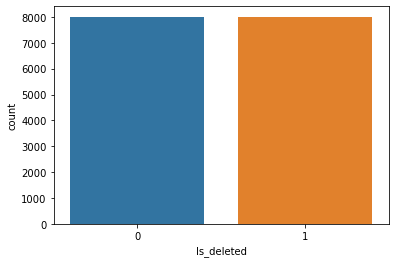

In [40]:
sns.countplot(x = y_train)

<AxesSubplot:xlabel='Is_deleted', ylabel='count'>

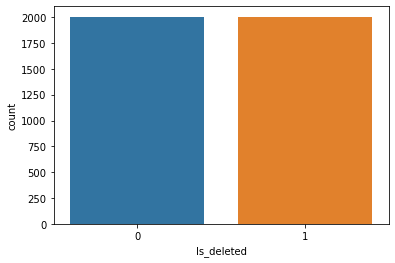

In [41]:
sns.countplot(x = y_test)

In [39]:
l_regression = fit_log_reg(X_train,y_train)

In [40]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/TweetsCov19_LR_Inhalt_all_ohne_moderacy.sav'
pickle.dump(l_regression, open(pfad_modell, 'wb'))

In [41]:
y_prob = l_regression.predict_proba(X_test)

In [42]:
print('Accuracy without useres features is : ',l_regression.score(X_train, y_train))

Accuracy without useres features is :  0.5673463253373318


In [43]:
y_pred = l_regression.predict(X_train)
y_prob = l_regression.predict_proba(X_train)
y_prob_test = l_regression.predict_proba(X_test)


In [44]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.58      0.50      0.53   1709564
           1       0.56      0.64      0.60   1710437

    accuracy                           0.57   3420001
   macro avg       0.57      0.57      0.57   3420001
weighted avg       0.57      0.57      0.57   3420001



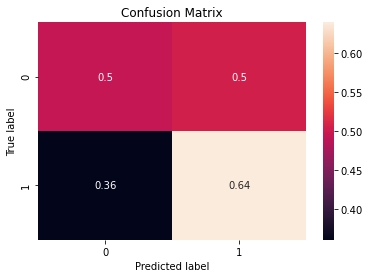

In [45]:
confusion_mx = confusion_matrix(y_train, y_pred)
confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(confusion_mx, l_regression.classes_, 'Confusion Matrix')

In [46]:
print('Logarithmic loss für Training data', log_loss(y_train, y_prob))
print('Logarithmic loss für Test data', log_loss(y_test, y_prob_test))

Logarithmic loss für Training data 0.6801963020334549
Logarithmic loss für Test data 0.6800949365967058


In [47]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/TweetsCov19_LR_Inhalt_all_ohne_moderacy.sav'
#l_regression = pickle.load(open(pfad_modell, 'rb'))

In [48]:
scores = cross_val_score(l_regression, X_test, y_test, cv=10, scoring='precision')
print(" percision %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(l_regression, X_test, y_test, cv=10, scoring='f1')
print(" f1        %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(l_regression, X_test, y_test, cv=10, scoring='recall')
print(" recall    %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

 percision 0.56 +/- 0.003
 f1        0.60 +/- 0.005
 recall    0.64 +/- 0.015


****************************************************************
****************************************************************

## *(2)Tweetskb*
### (Content + User feature)

In [7]:
#pfad_tsv = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/TweetsFormodel/tweetskb_sample_with_users_1_51.tsv'
pfad_tsv = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/TweetsKB_alle_geloeschten/TweetsKB_all_del_posted.tsv'

df_tweetskb_user = pd.read_csv(pfad_tsv, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Is_deleted', 'Retweets', 'Likes', 'Sentiment', 'Hashtags n.', 'Mentions n.', 'Text l.', 'URLs n.', 'Readability', 'Emoji n.', 'Emoji sentiment', 'Political p.T.', 'Science p.T.', 'Moderacy p.T.', 'Porn(Shalla)', 'News(Shalla)', 'Socialnet(Shalla)', 'Social', 'Family', 'Friend', 'Female', 'Male' , 'Work', 'Leisure', 'Home', 'Money', 'Relegion', 'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonfluence', 'Filler', 'Body', 'Health', 'Sexual', 'Ingest', 'Pos. emo.', 'Neg. emo.', 'Anxiety', 'Anger', 'Sadness', 'Insight', 'Cause', 'Discrep', 'Tentativness', 'Certainty', 'Differentiation', 'Affiliation', 'Achieve', 'Power', 'Reward', 'Risk', 'Focus past', 'Focus present', 'Focus future', 'I', 'We', 'You', 'SheHe', 'They', 'Ipron', 'Article', 'Preposition', 'Auxverb', 'Adverb', 'Conjunctive', 'Negate', 'Verb', 'Adjective', 'Compare', 'Interrogative', 'Number', 'Quantitative', 'See', 'Hear', 'Feel', 'Motion', 'Space', 'Time', 'Political p.u.', 'Science p.u.', 'Moderacy p.u.', 'Posted n.', 'Deleted n.', 'Deletion ratio', 'Reputation' ])
pd.options.display.max_columns = None
print('Shape :', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape : (5445154, 90)


,Tweet_Id,Username,Is_deleted,Retweets,Likes,Sentiment,Hashtags n.,Mentions n.,Text l.,URLs n.,Readability,Emoji n.,Emoji sentiment,Political p.T.,Science p.T.,Moderacy p.T.,Porn(Shalla),News(Shalla),Socialnet(Shalla),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonfluence,Filler,Body,Health,Sexual,Ingest,Pos. emo.,Neg. emo.,Anxiety,Anger,Sadness,Insight,Cause,Discrep,Tentativness,Certainty,Differentiation,Affiliation,Achieve,Power,Reward,Risk,Focus past,Focus present,Focus future,I,We,You,SheHe,They,Ipron,Article,Preposition,Auxverb,Adverb,Conjunctive,Negate,Verb,Adjective,Compare,Interrogative,Number,Quantitative,See,Hear,Feel,Motion,Space,Time,Political p.u.,Science p.u.,Moderacy p.u.,Posted n.,Deleted n.,Deletion ratio,Reputation
0,1234421176492912641,Jhenkyuttttt,False,3,7,0.3182,0,0,35,0,75.8750,1,0.3530,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.5025
1,1203032264038326273,EdS_888,False,0,0,-0.2396,0,1,208,0,81.2070,0,0.0000,0,0,0,0.0000,0.0000,0.0000,21.0500,0.0000,5.2600,0.0000,7.8900,2.6300,2.6300,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,2.6300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,5.2600,0.0000,2.6300,0.0000,5.2600,2.6300,2.6300,0.0000,0.0000,2.6300,2.6300,2.6300,2.6300,0.0000,2.6300,7.8900,10.5300,2.6300,0.0000,0.0000,5.2600,2.6300,0.0000,5.2600,5.2600,13.1600,7.8900,0.0000,7.8900,2.6300,21.0500,10.5300,10.5300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.6300,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.5110
2,1240505249724616705,Official_Lavan,False,0,0,0.9356,1,0,115,0,95.9550,2,0.6650,0,0,0,0.0000,0.0000,0.0000,22.7300,0.0000,4.5500,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,4.5500,0.0000,13.6400,0.0000,0.0000,0.0000,9.0900,4.5500,0.0000,4.5500,0.0000,4.5500,13.6400,0.0000,0.0000,0.0000,13.6400,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,2,1,0.5000,0.2500
3,1248234798390231045,chenfongthing,False,12,12,0.3182,0,0,107,0,87.3000,1,0.6910,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,9.0900,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,4.5500,0.0000,4.5500,9.0900,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,4.5500,4.5500,0.0000,13.6400,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,6,0,0.0000,0.4367
4,1221967294273851393,Joy_Anna15,False,0,0,0.6260,1,0,54,0,77.3980,0,0.0000,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.2551


In [8]:
df_tweetskb_user.head()

,Tweet_Id,Username,Is_deleted,Retweets,Likes,Sentiment,Hashtags n.,Mentions n.,Text l.,URLs n.,Readability,Emoji n.,Emoji sentiment,Political p.T.,Science p.T.,Moderacy p.T.,Porn(Shalla),News(Shalla),Socialnet(Shalla),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonfluence,Filler,Body,Health,Sexual,Ingest,Pos. emo.,Neg. emo.,Anxiety,Anger,Sadness,Insight,Cause,Discrep,Tentativness,Certainty,Differentiation,Affiliation,Achieve,Power,Reward,Risk,Focus past,Focus present,Focus future,I,We,You,SheHe,They,Ipron,Article,Preposition,Auxverb,Adverb,Conjunctive,Negate,Verb,Adjective,Compare,Interrogative,Number,Quantitative,See,Hear,Feel,Motion,Space,Time,Political p.u.,Science p.u.,Moderacy p.u.,Posted n.,Deleted n.,Deletion ratio,Reputation
0,1234421176492912641,Jhenkyuttttt,False,3,7,0.3182,0,0,35,0,75.8750,1,0.3530,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.5025
1,1203032264038326273,EdS_888,False,0,0,-0.2396,0,1,208,0,81.2070,0,0.0000,0,0,0,0.0000,0.0000,0.0000,21.0500,0.0000,5.2600,0.0000,7.8900,2.6300,2.6300,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,2.6300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,5.2600,0.0000,2.6300,0.0000,5.2600,2.6300,2.6300,0.0000,0.0000,2.6300,2.6300,2.6300,2.6300,0.0000,2.6300,7.8900,10.5300,2.6300,0.0000,0.0000,5.2600,2.6300,0.0000,5.2600,5.2600,13.1600,7.8900,0.0000,7.8900,2.6300,21.0500,10.5300,10.5300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.6300,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.5110
2,1240505249724616705,Official_Lavan,False,0,0,0.9356,1,0,115,0,95.9550,2,0.6650,0,0,0,0.0000,0.0000,0.0000,22.7300,0.0000,4.5500,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,4.5500,0.0000,13.6400,0.0000,0.0000,0.0000,9.0900,4.5500,0.0000,4.5500,0.0000,4.5500,13.6400,0.0000,0.0000,0.0000,13.6400,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,2,1,0.5000,0.2500
3,1248234798390231045,chenfongthing,False,12,12,0.3182,0,0,107,0,87.3000,1,0.6910,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,9.0900,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,4.5500,0.0000,4.5500,9.0900,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,4.5500,4.5500,0.0000,13.6400,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,6,0,0.0000,0.4367
4,1221967294273851393,Joy_Anna15,False,0,0,0.6260,1,0,54,0,77.3980,0,0.0000,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.2551


In [9]:
df_tweetskb_user.Username.unique().size

3378025

In [54]:
df_tweetskb_del = df_tweetskb_user[df_tweetskb_user['Is_deleted']==True]
df_tweetskb_undel = df_tweetskb_user[df_tweetskb_user['Is_deleted']==False]

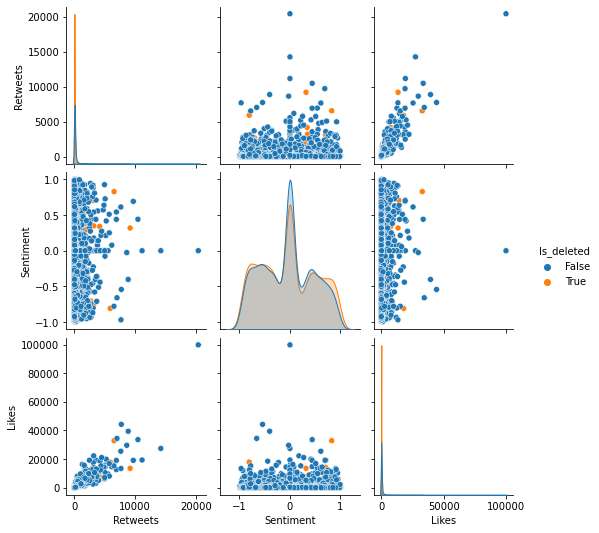

In [139]:
df = df_tweetskb_user[['Is_deleted', 'Retweets', 'Sentiment', 'Likes']]
plot_paiplot(df, 'Is_deleted', 'pairplot_tweetskb_Retweet_favoriet_sentiment')

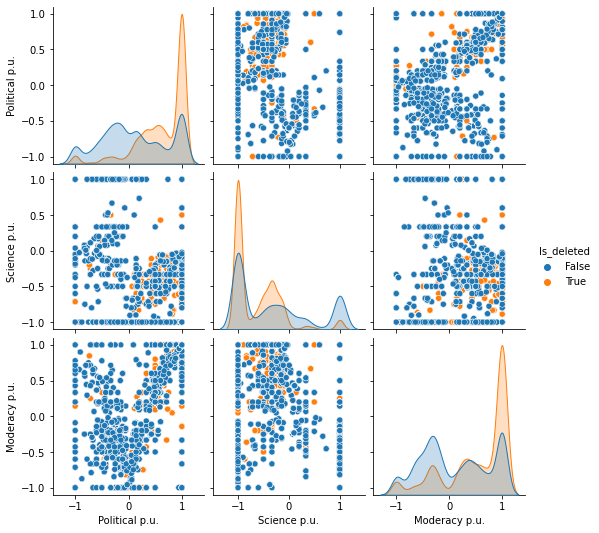

In [140]:
df = df_tweetskb_user[['Is_deleted', 'Political p.u.', 'Science p.u.', 'Moderacy p.u.']]
plot_paiplot(df, 'Is_deleted', 'pairplot_tweetskb_politic_science_moderacy')

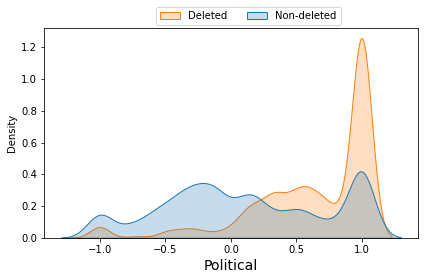

In [141]:
df = df_tweetskb_user[['Is_deleted', 'Political p.u.']]
plot_kdeplot(df, 'Is_deleted','Political p.u.', 'Political', 'TweetsKB','pairplot_tweetskb_politicd')

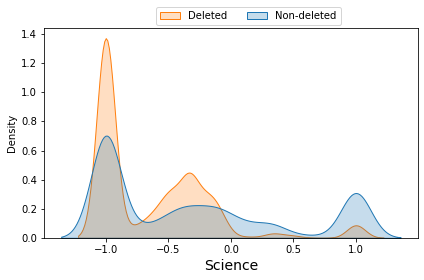

In [143]:
df = df_tweetskb_user[['Is_deleted', 'Science p.u.']]
plot_kdeplot(df, 'Is_deleted','Science p.u.','Science', 'TweetsKB' ,'pairplot_tweetskb_science')

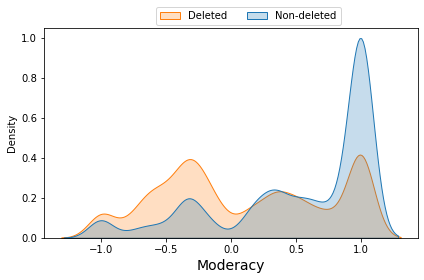

In [159]:
df = df_tweetskb_user[['Is_deleted', 'Moderacy p.u.']]
plot_kdeplot(df, 'Is_deleted','Moderacy p.u.','Moderacy', 'TweetsKB' ,'pairplot_tweetskb_moderacy')

<AxesSubplot:xlabel='Is_deleted', ylabel='count'>

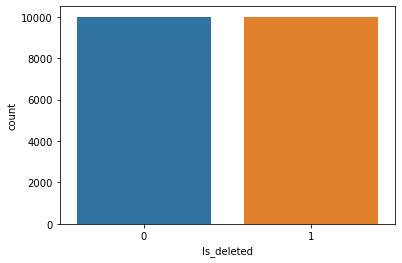

In [160]:
sns.countplot(x = 'Is_deleted', data = df)

In [10]:
features = df_tweetskb_user.columns
features

Index(['Tweet_Id', 'Username', 'Is_deleted', 'Retweets', 'Likes', 'Sentiment',
       'Hashtags n.', 'Mentions n.', 'Text l.', 'URLs n.', 'Readability',
       'Emoji n.', 'Emoji sentiment', 'Political p.T.', 'Science p.T.',
       'Moderacy p.T.', 'Porn(Shalla)', 'News(Shalla)', 'Socialnet(Shalla)',
       'Social', 'Family', 'Friend', 'Female', 'Male', 'Work', 'Leisure',
       'Home', 'Money', 'Relegion', 'Death', 'Informal', 'Swear', 'Netspeak',
       'Assent', 'Nonfluence', 'Filler', 'Body', 'Health', 'Sexual', 'Ingest',
       'Pos. emo.', 'Neg. emo.', 'Anxiety', 'Anger', 'Sadness', 'Insight',
       'Cause', 'Discrep', 'Tentativness', 'Certainty', 'Differentiation',
       'Affiliation', 'Achieve', 'Power', 'Reward', 'Risk', 'Focus past',
       'Focus present', 'Focus future', 'I', 'We', 'You', 'SheHe', 'They',
       'Ipron', 'Article', 'Preposition', 'Auxverb', 'Adverb', 'Conjunctive',
       'Negate', 'Verb', 'Adjective', 'Compare', 'Interrogative', 'Number',
       'Quanti

In [11]:
df_tweetskb_user['Is_deleted'] = np.where(df_tweetskb_user['Is_deleted'] == True, 0, 1)
df_tweetskb_user.head()

,Tweet_Id,Username,Is_deleted,Retweets,Likes,Sentiment,Hashtags n.,Mentions n.,Text l.,URLs n.,Readability,Emoji n.,Emoji sentiment,Political p.T.,Science p.T.,Moderacy p.T.,Porn(Shalla),News(Shalla),Socialnet(Shalla),Social,Family,Friend,Female,Male,Work,Leisure,Home,Money,Relegion,Death,Informal,Swear,Netspeak,Assent,Nonfluence,Filler,Body,Health,Sexual,Ingest,Pos. emo.,Neg. emo.,Anxiety,Anger,Sadness,Insight,Cause,Discrep,Tentativness,Certainty,Differentiation,Affiliation,Achieve,Power,Reward,Risk,Focus past,Focus present,Focus future,I,We,You,SheHe,They,Ipron,Article,Preposition,Auxverb,Adverb,Conjunctive,Negate,Verb,Adjective,Compare,Interrogative,Number,Quantitative,See,Hear,Feel,Motion,Space,Time,Political p.u.,Science p.u.,Moderacy p.u.,Posted n.,Deleted n.,Deletion ratio,Reputation
0,1234421176492912641,Jhenkyuttttt,1,3,7,0.3182,0,0,35,0,75.8750,1,0.3530,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.5025
1,1203032264038326273,EdS_888,1,0,0,-0.2396,0,1,208,0,81.2070,0,0.0000,0,0,0,0.0000,0.0000,0.0000,21.0500,0.0000,5.2600,0.0000,7.8900,2.6300,2.6300,0.0000,0.0000,0.0000,0.0000,5.2600,0.0000,2.6300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.2600,5.2600,0.0000,2.6300,0.0000,5.2600,2.6300,2.6300,0.0000,0.0000,2.6300,2.6300,2.6300,2.6300,0.0000,2.6300,7.8900,10.5300,2.6300,0.0000,0.0000,5.2600,2.6300,0.0000,5.2600,5.2600,13.1600,7.8900,0.0000,7.8900,2.6300,21.0500,10.5300,10.5300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.6300,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.5110
2,1240505249724616705,Official_Lavan,1,0,0,0.9356,1,0,115,0,95.9550,2,0.6650,0,0,0,0.0000,0.0000,0.0000,22.7300,0.0000,4.5500,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,4.5500,0.0000,13.6400,0.0000,0.0000,0.0000,9.0900,4.5500,0.0000,4.5500,0.0000,4.5500,13.6400,0.0000,0.0000,0.0000,13.6400,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,2,1,0.5000,0.2500
3,1248234798390231045,chenfongthing,1,12,12,0.3182,0,0,107,0,87.3000,1,0.6910,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,9.0900,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,4.5500,0.0000,4.5500,9.0900,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,4.5500,4.5500,0.0000,13.6400,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,6,0,0.0000,0.4367
4,1221967294273851393,Joy_Anna15,1,0,0,0.6260,1,0,54,0,77.3980,0,0.0000,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.2551


In [12]:
features = features[2:90]

In [13]:
df_tweetskb_user_2 = df_tweetskb_user[features.tolist()]
df_tweetskb_user_2 = df_tweetskb_user_2.drop(columns=[  'Moderacy p.T.','Moderacy p.u.', 'Posted n.', 'Deleted n.', 'Deletion ratio'])
df = df_tweetskb_user_2.drop('Is_deleted', axis=1)
X = df_tweetskb_user_2.drop('Is_deleted', axis=1).values
y = df_tweetskb_user_2['Is_deleted']

y = y.astype(int)
print(X.shape)
print(y.shape)

(5445154, 82)
(5445154,)


In [14]:
features_cl = features_classifier(df , X, y)
features_cl

,index,Feature,importance
0,81,Reputation,0.2455
1,6,URLs n.,0.1102
2,62,Preposition,0.1000
3,55,I,0.0977
4,79,Political p.u.,0.0871
5,26,Informal,0.0494
6,4,Mentions n.,0.0420
7,80,Science p.u.,0.0301
8,5,Text l.,0.0300
9,3,Hashtags n.,0.0277


In [15]:
features_cl = features_cl[features_cl['importance']>0]
features_cl = features_cl.Feature.values
print(features_cl)

['Reputation' 'URLs n.' 'Preposition' 'I' 'Political p.u.' 'Informal'
 'Mentions n.' 'Science p.u.' 'Text l.' 'Hashtags n.' 'Sexual'
 'Porn(Shalla)' 'Sentiment' 'News(Shalla)' 'Work' 'Retweets' 'Emoji n.'
 'Verb' 'Socialnet(Shalla)' 'Netspeak' 'Likes' 'Swear' 'Social' 'You'
 'Anger' 'Emoji sentiment' 'Ipron' 'Assent' 'Time' 'Science p.T.' 'Body'
 'Money' 'Space' 'Readability' 'Affiliation' 'Pos. emo.' 'Number'
 'Focus past' 'Focus present' 'Adjective' 'Adverb' 'Tentativness' 'Motion'
 'Negate' 'Discrep' 'Differentiation' 'Power' 'Conjunctive'
 'Interrogative' 'Insight' 'Achieve' 'Article' 'Feel' 'Reward' 'Neg. emo.'
 'Health' 'Home' 'Cause' 'Quantitative' 'Female' 'Certainty' 'Ingest'
 'Auxverb' 'See' 'Compare' 'Family' 'Male' 'Focus future' 'Relegion'
 'Hear' 'Friend' 'Leisure' 'Sadness' 'Risk' 'SheHe' 'Death' 'Nonfluence']


In [16]:
#X = df_tweetskb_user[features_cl.tolist()].values
X.shape

(5445154, 82)

In [17]:
X_train, X_test, y_train, y_test  = split_train_test_valid(X,y)

(4356123, 82)
(1089031, 82)
(4356123,)
(1089031,)


<AxesSubplot:xlabel='Is_deleted', ylabel='count'>

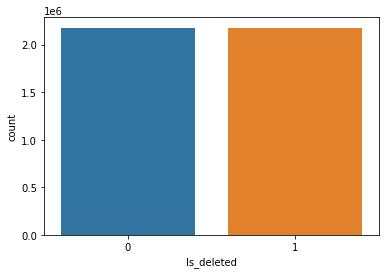

In [18]:
sns.countplot(x = y_train)

<AxesSubplot:xlabel='Is_deleted', ylabel='count'>

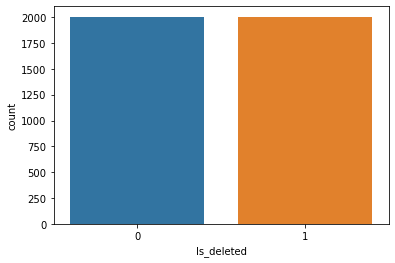

In [64]:
sns.countplot(x = y_test)

In [19]:
l_regression = fit_log_reg(X_train, y_train)

In [20]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/Modells/TweetsKB_LR_Benutzer_Inhalt_alle_ohne_moderacy.sav'
pickle.dump(l_regression, open(pfad_modell, 'wb'))

In [21]:
y_prob = l_regression.predict_proba(X_test)

In [22]:
print('Accuracy with useres featuresis : ',l_regression.score(X_train, y_train))

Accuracy with useres featuresis :  0.5535339566857961


In [23]:
y_pred = l_regression.predict(X_train)
y_prob = l_regression.predict_proba(X_train)
y_prob_test = l_regression.predict_proba(X_test)


In [24]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.56      0.52      0.54   2178121
           1       0.55      0.59      0.57   2178002

    accuracy                           0.55   4356123
   macro avg       0.55      0.55      0.55   4356123
weighted avg       0.55      0.55      0.55   4356123



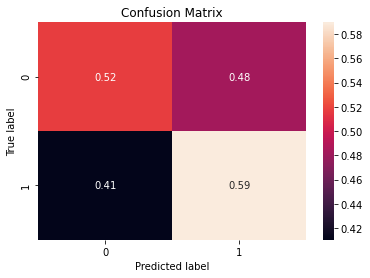

In [25]:
confusion_mx = confusion_matrix(y_train, y_pred)
confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(confusion_mx, l_regression.classes_, 'Confusion Matrix')

In [26]:
print('Logarithmic loss für Training data', log_loss(y_train, y_prob))
print('Logarithmic loss für Test data', log_loss(y_test, y_prob_test))

Logarithmic loss für Training data 0.6861140238813914
Logarithmic loss für Test data 0.6862349289130182


In [27]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/Modells/TweetsKB_LR_Benutzer_Inhalt_alle_ohne_moderacy.sav'
#l_regression = pickle.load(open(pfad_modell, 'rb'))

In [28]:
scores = cross_val_score(l_regression, X_test, y_test, cv=10, scoring='precision')
print(" percision %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(l_regression, X_test, y_test, cv=10, scoring='f1')
print(" f1        %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(l_regression, X_test, y_test, cv=10, scoring='recall')
print(" recall    %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

 percision 0.55 +/- 0.001
 f1        0.57 +/- 0.003
 recall    0.59 +/- 0.007


**********************************************************************
**********************************************************************

### Tweetskb
#### (Content only)

In [29]:
features = df_tweetskb_user.columns
features

features = features[2:83]
df_tweetskb_user_2 = df_tweetskb_user[features.tolist()]
df_tweetskb_user_2 = df_tweetskb_user_2.drop(columns=[ 'Moderacy p.T.'])

df = df_tweetskb_user_2.drop('Is_deleted', axis=1)
X = df_tweetskb_user_2.drop('Is_deleted', axis=1).values
y = df_tweetskb_user_2['Is_deleted']

y = y.astype(int)
print(X.shape)
print(y.shape)

(5445154, 79)
(5445154,)


In [30]:
features

Index(['Is_deleted', 'Retweets', 'Likes', 'Sentiment', 'Hashtags n.',
       'Mentions n.', 'Text l.', 'URLs n.', 'Readability', 'Emoji n.',
       'Emoji sentiment', 'Political p.T.', 'Science p.T.', 'Moderacy p.T.',
       'Porn(Shalla)', 'News(Shalla)', 'Socialnet(Shalla)', 'Social', 'Family',
       'Friend', 'Female', 'Male', 'Work', 'Leisure', 'Home', 'Money',
       'Relegion', 'Death', 'Informal', 'Swear', 'Netspeak', 'Assent',
       'Nonfluence', 'Filler', 'Body', 'Health', 'Sexual', 'Ingest',
       'Pos. emo.', 'Neg. emo.', 'Anxiety', 'Anger', 'Sadness', 'Insight',
       'Cause', 'Discrep', 'Tentativness', 'Certainty', 'Differentiation',
       'Affiliation', 'Achieve', 'Power', 'Reward', 'Risk', 'Focus past',
       'Focus present', 'Focus future', 'I', 'We', 'You', 'SheHe', 'They',
       'Ipron', 'Article', 'Preposition', 'Auxverb', 'Adverb', 'Conjunctive',
       'Negate', 'Verb', 'Adjective', 'Compare', 'Interrogative', 'Number',
       'Quantitative', 'See', 'Hear', 

In [31]:
features_cl = features_classifier(df , X, y)
features_cl

,index,Feature,importance
0,6,URLs n.,0.1432
1,62,Preposition,0.1189
2,55,I,0.1181
3,26,Informal,0.0625
4,4,Mentions n.,0.0565
5,3,Hashtags n.,0.0537
6,0,Retweets,0.0501
7,34,Sexual,0.0487
8,5,Text l.,0.0416
9,20,Work,0.0391


In [32]:
features_cl = features_cl[features_cl['importance']>0]
features_cl = features_cl.Feature.values
print(features_cl)

['URLs n.' 'Preposition' 'I' 'Informal' 'Mentions n.' 'Hashtags n.'
 'Retweets' 'Sexual' 'Text l.' 'Work' 'Sentiment' 'Emoji n.'
 'Political p.T.' 'Likes' 'Socialnet(Shalla)' 'News(Shalla)'
 'Porn(Shalla)' 'Science p.T.' 'Social' 'Netspeak' 'Swear' 'Verb' 'Money'
 'Anger' 'Emoji sentiment' 'You' 'Ipron' 'Readability' 'Article' 'Discrep'
 'Time' 'Affiliation' 'Assent' 'Space' 'Body' 'Certainty' 'Female'
 'Number' 'Auxverb' 'Pos. emo.' 'Home' 'Differentiation' 'Health'
 'Leisure' 'Reward' 'Adjective' 'Focus present' 'Focus past' 'Neg. emo.'
 'Power' 'Negate' 'Conjunctive' 'Compare' 'See' 'Adverb' 'Interrogative'
 'Family' 'Insight' 'Ingest' 'Tentativness' 'SheHe' 'Male' 'Hear' 'Cause'
 'They' 'Death' 'Motion' 'We' 'Feel' 'Nonfluence' 'Risk' 'Quantitative'
 'Sadness' 'Relegion' 'Achieve' 'Focus future' 'Friend' 'Anxiety']


In [33]:
#X = df_tweetscov19_user_2[features_cl.tolist()].values
X.shape

(5445154, 79)

In [34]:
X_train, X_test, y_train, y_test  = split_train_test_valid(X,y)

(4356123, 79)
(1089031, 79)
(4356123,)
(1089031,)


<AxesSubplot:xlabel='Is_deleted', ylabel='count'>

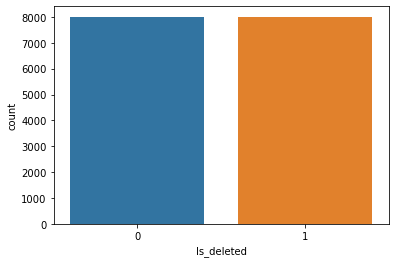

In [81]:
sns.countplot(x = y_train)

<AxesSubplot:xlabel='Is_deleted', ylabel='count'>

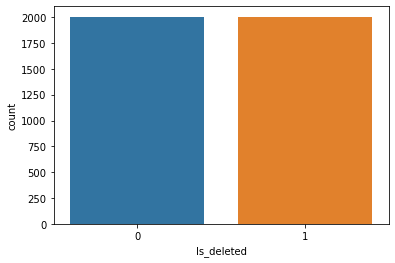

In [82]:
sns.countplot(x = y_test)

In [35]:
l_regression = fit_log_reg(X_train, y_train)

In [36]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/Modells/TweetsKB_LR_Inhalt_alle_ohne_moderacy.sav'
pickle.dump(l_regression, open(pfad_modell, 'wb'))

In [37]:
print('Accuracy without useres features is : ',l_regression.score(X_train, y_train))


Accuracy without useres features is :  0.5531324528715098


In [38]:
y_pred = l_regression.predict(X_train)
y_prob = l_regression.predict_proba(X_train)
y_prob_test = l_regression.predict_proba(X_test)


In [39]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.56      0.52      0.54   2178121
           1       0.55      0.58      0.57   2178002

    accuracy                           0.55   4356123
   macro avg       0.55      0.55      0.55   4356123
weighted avg       0.55      0.55      0.55   4356123



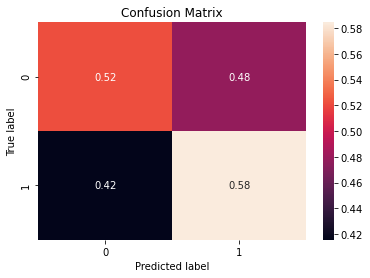

In [40]:
confusion_mx = confusion_matrix(y_train, y_pred)
confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(confusion_mx, l_regression.classes_, 'Confusion Matrix')

In [41]:
print('Logarithmic loss für Training data', log_loss(y_train, y_prob))
print('Logarithmic loss für Test data', log_loss(y_test, y_prob_test))

Logarithmic loss für Training data 0.6859997270131609
Logarithmic loss für Test data 0.6860934903177099


In [42]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/Modells/TweetsKB_LR_Inhalt_alle_ohne_moderacy.sav'
#l_regression = pickle.load(open(pfad_modell, 'rb'))

In [43]:
scores = cross_val_score(l_regression, X_test, y_test, cv=10, scoring='precision')
print(" percision %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(l_regression, X_test, y_test, cv=10, scoring='f1')
print(" f1        %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(l_regression, X_test, y_test, cv=10, scoring='recall')
print(" recall    %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

 percision 0.55 +/- 0.001
 f1        0.57 +/- 0.002
 recall    0.59 +/- 0.005
